In [1]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
NUM_CLASSES  = 5
# NUM_CLASSES  = 3  # 2 stage models
CHANNEL_SIZE = 3

# pre_process = str(IMG_DIM) + "_ben_normal_"

# pre_process = str(IMG_DIM) + "_ben_weird_"

pre_process = str(IMG_DIM) + "_clahe_"


Using TensorFlow backend.
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python

# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

In [2]:
# data frame of current competition
df_2019 = pd.read_csv("../aptos2019/train.csv") 
df_2019.processed = df_2019.id_code.apply(lambda x: pre_process + x + ".png")
df_2019["original"]  = df_2019.id_code.apply(lambda x: x + ".png")
df_2019["processed"] = df_2019.original.apply(lambda x: pre_process + x)
# train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False) not for python 3.5
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, random_state=42)

# 2019 data frame 
df_2015 = pd.read_csv("../aptos2015/trainLabels.csv") 
df_2015["original"]  = df_2015.image.apply(lambda x: x + ".jpeg")
df_2015["processed"] = df_2015.original.apply(lambda x: pre_process + x)
df_2015["diagnosis"] = df_2015.level
# train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, random_state=42)

valid_2019['diagnosis'].value_counts().plot(kind='bar')
print(valid_2019[:3])
plt.title('Samples Per Class')


           id_code  diagnosis          original                   processed
2059  90960ddf4d14          0  90960ddf4d14.png  256_clahe_90960ddf4d14.png
1105  4e0656629d02          1  4e0656629d02.png  256_clahe_4e0656629d02.png
818   3b018e8b7303          3  3b018e8b7303.png  256_clahe_3b018e8b7303.png


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Samples Per Class')

In [3]:
def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    return y_val

def get_train_valid_df(year="2019", style="normal", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    if style == "normal":
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x+1)])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x+1)])
    elif style == "stage_1":
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(min(x+1, 3))])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(min(x+1, 3))])
    elif style == "stage_2":
#         train = train[train.diagnosis != 0]
#         train = train[train.diagnosis != 1]
#         valid = valid[valid.diagnosis != 0]
#         valid = valid[valid.diagnosis != 1]
        train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(max(x-1, 1))])
        valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(max(x-1, 1))])
    else:
        print("Error: " + style + " style not implemented.")
        exit()

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())
        
        for diagnosis in range(0 if style != "stage_2" else 0, 5):
            indexes_train = train[train['diagnosis'] == diagnosis].index
            indexes_valid = valid[valid['diagnosis'] == diagnosis].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution, also decrease the overall amount to a max of 4,000 
    # with a prop drop in valid
    
    frac = 0.7
    if train.index.size > 5000:
        frac = 5000/train.index.size
        print(frac)
    train = train.sample(frac=frac)
    valid = valid.sample(frac=frac)
    
    return train, valid

df_sample, _ = get_train_valid_df(year="2019", style="normal")
print(df_sample.head())

           id_code  diagnosis          original                   processed  \
1476  675de69373f8          0  675de69373f8.png  256_clahe_675de69373f8.png   
2189  9a1029536d78          0  9a1029536d78.png  256_clahe_9a1029536d78.png   
413   1db0393cdbc1          0  1db0393cdbc1.png  256_clahe_1db0393cdbc1.png   
2435  a9a28c37c8c4          2  a9a28c37c8c4.png  256_clahe_a9a28c37c8c4.png   
2051  9033f1493da1          2  9033f1493da1.png  256_clahe_9033f1493da1.png   

         labels  
1476        [0]  
2189        [0]  
413         [0]  
2435  [0, 1, 2]  
2051  [0, 1, 2]  


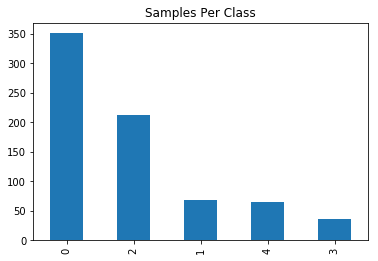

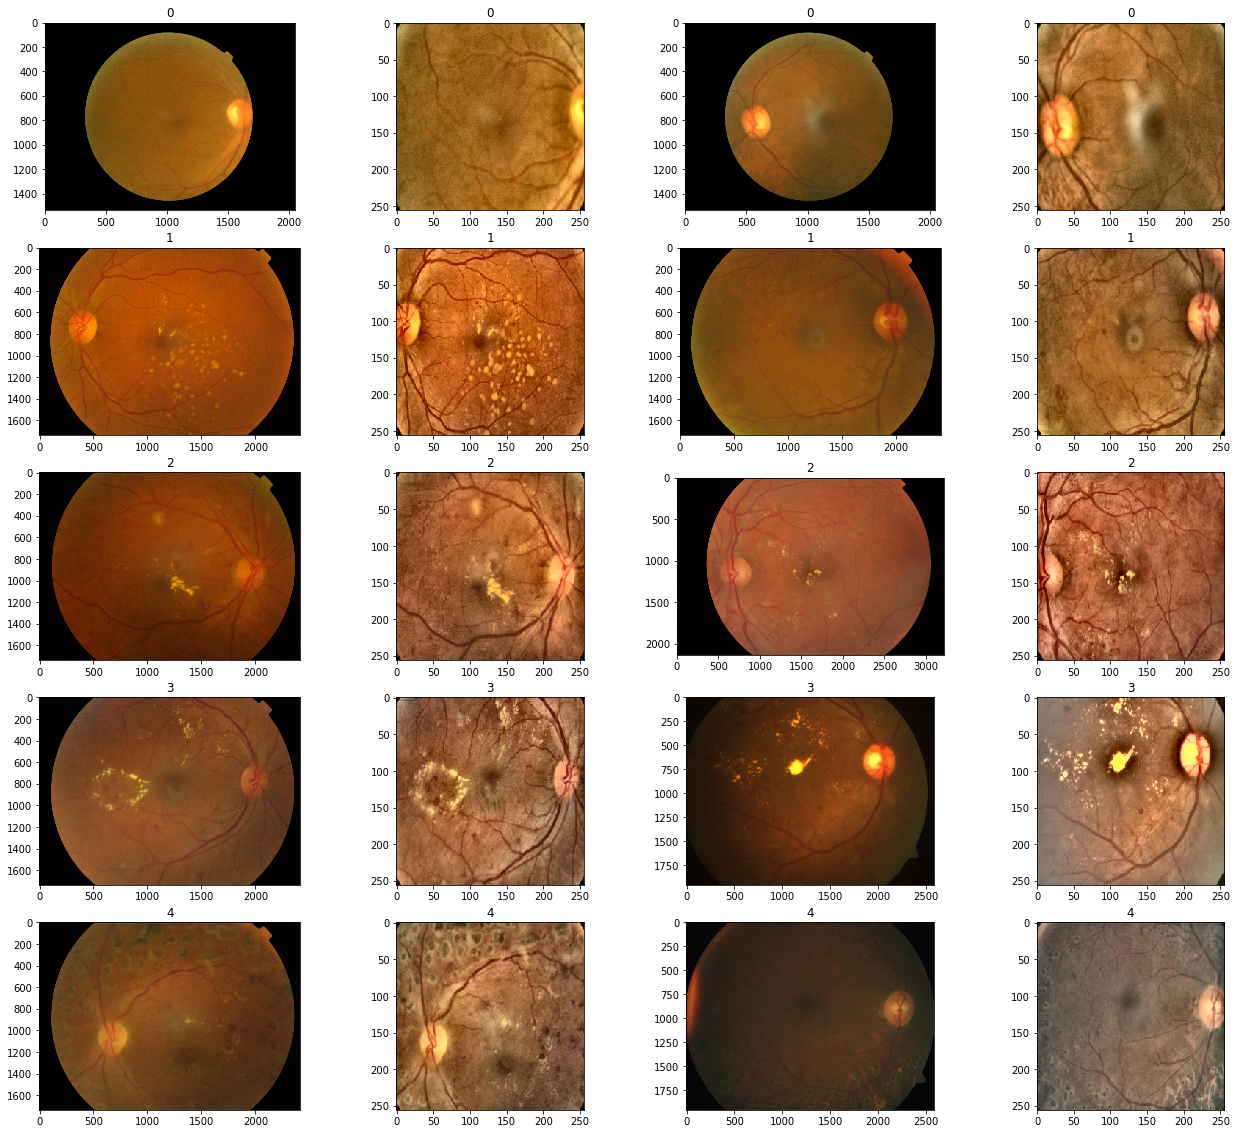

In [4]:
# display some data
def display_data():
    df_example, _ = get_train_valid_df(year="2019")

    # Display some random images from Data Set with class categories.
    figure=plt.figure(figsize=(22,20))
    for target_class in range(5):
        for i, file_name in enumerate(df_example[df_example.diagnosis == target_class].original.sample(2)):
            
            # open the file
            o_img = cv2.imread("../aptos2019/train_images/" + file_name)
            p_img = cv2.imread("../aptos2019/train_images/" + pre_process + file_name)

            o_rgb = cv2.cvtColor(o_img, cv2.COLOR_BGR2RGB)
            p_rgb = cv2.cvtColor(p_img, cv2.COLOR_BGR2RGB)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
            plt.imshow(o_rgb)
            ax.set_title(target_class)
            
            ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
            plt.imshow(p_rgb)
            ax.set_title(target_class)
    
    plt.show()
            
display_data()

In [5]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True and (jitter > 0.01), 
                                       vertical_flip=True and (jitter > 0.01),
                                       rotation_range=int(600*jitter),
                                       brightness_range=[1-jitter/3, 1+jitter/3],
                                       channel_shift_range=int(30*jitter),
                                       zoom_range=[max(0.9, 1-5*jitter), 1],
                                       fill_mode="mirror",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="processed", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True, style="normal"):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib, style=style) 
    datagen_jittered = dataGenerator(jitter)
    datagen_clean = dataGenerator(0.02)
    
    train_gen = datagen_with_flow(datagen_jittered, train, "../aptos" + year + "/train_images/")
    valid_gen = datagen_with_flow(datagen_clean, valid, "../aptos" + year + "/train_images/")
    
    return train_gen, valid_gen

gc.collect()


41724

Found 550 validated image filenames belonging to 5 classes.
Found 127 validated image filenames belonging to 5 classes.


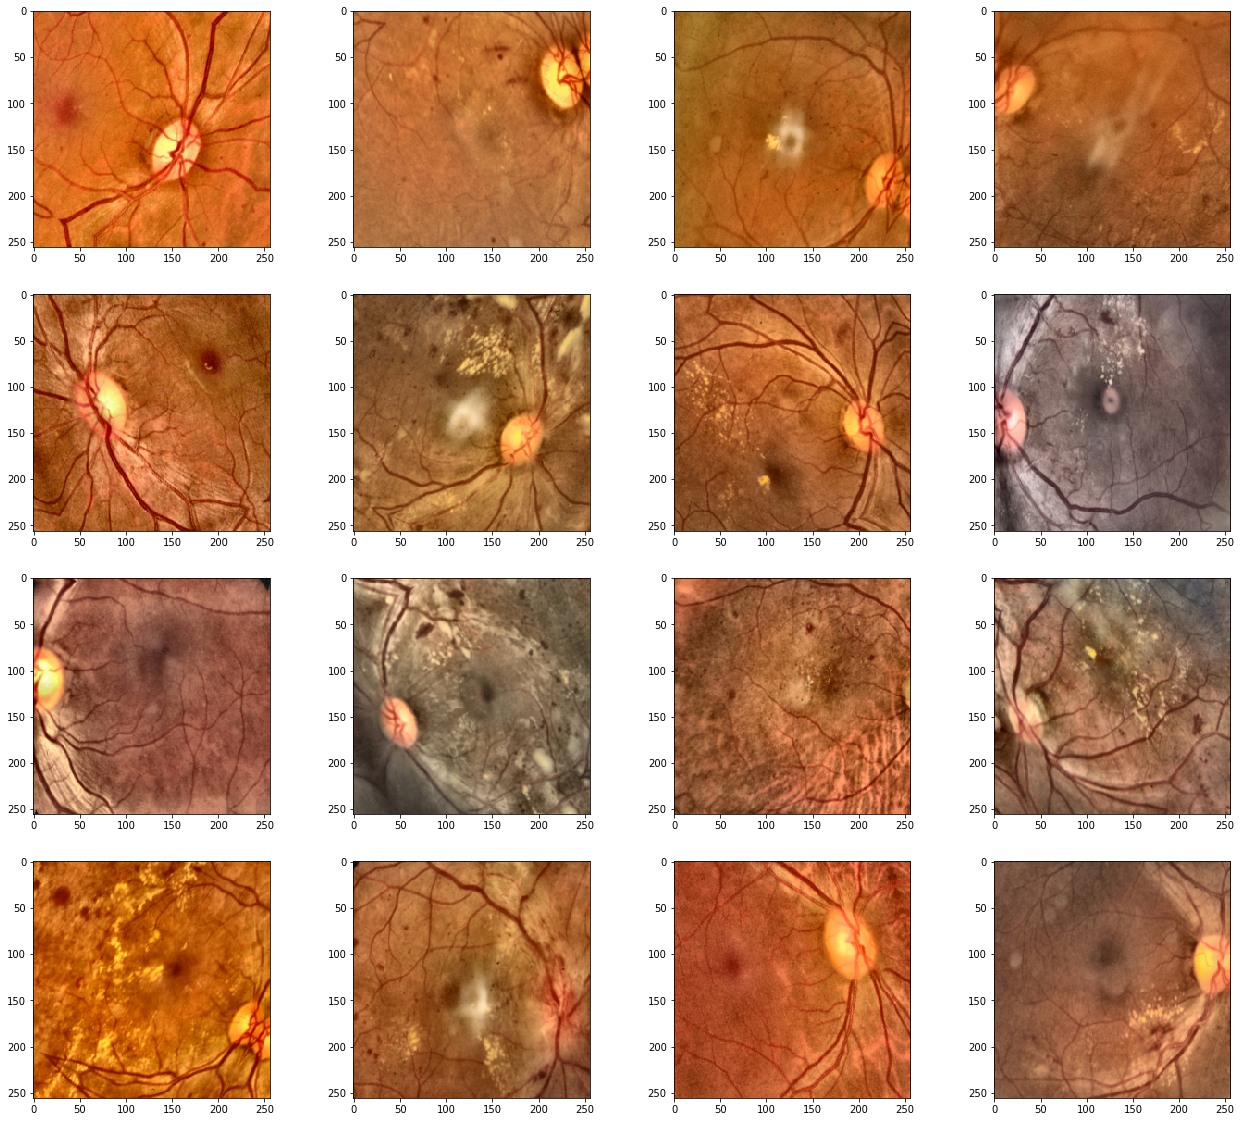

In [6]:
train_sample_gen, valid_sample_gen = generator(jitter=0.05, style="normal")

# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in train_sample_gen:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break
plt.show()

In [7]:
class Metrics(Callback):
    def __init__(self, generator, style):
        self.style = style
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 20
        y_pred     = []
        y_val      = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            y_pred.extend(label_convert(predictions > 0.5))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(confusion_matrix(y_val, y_pred), val_kappa)
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.88:
#         if val_kappa == max(self.val_kappas) and val_kappa > 0.85:
            gc.collect()
            print("Max of this run, saving model.")
            model.save("clahe_" + str(val_kappa) + ".h5")


In [8]:
def create_model():
    
    model = Sequential()
#     model.add(DenseNet121(weights='../DenseNet-BC-121-32-no-top.h5', 
    model.add(DenseNet121(weights=None, 
                          include_top=False, 
                          input_shape=(IMG_DIM, IMG_DIM, CHANNEL_SIZE)))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return model

model = create_model()



In [9]:
# model.load_weights("normal_0.9138864018922975.h5")

In [10]:

model.load_weights("dense-0.800.h5")
for style in ["normal"]:
    lr_start = 0.00002
    for year in [ "2015", "2015", "2019"]:
        lr = lr_start
        lr_start /= 2
        for jitter in [0.5, 0.3, 0.2, 0.1, 0.05]:
            lr *= 0.8
            model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy',  metrics=['accuracy'])
            # started at 0.00003. Seems to still change somewhat with even 0.000005

            print("           -----------------------------------", year, 
                  jitter, "-----------------------------------")

            for even_distrib in [True, True, True, False]:

                print("           -   -   -   -   -   -   -   -   ", 
                      even_distrib, "-   -   -   -   -   -   -   -   -")

                # these need to be global for the kappa callback
                train_generator, valid_generator = generator(jitter=jitter, 
                                                             year=year, 
                                                             even_distrib=even_distrib, 
                                                             style=style)

                # Call backs during training            
                kappa_callbacks = Metrics(valid_generator, style)
                reduce_lr  = ReduceLROnPlateau(monitor='val_loss', 
                                               min_delta=0.0004, 
                                               patience=2, 
                                               min_lr=1e-8, 
                                               mode='auto', verbose=1)

                # train the model for 12 epochs
                history = model.fit_generator(generator=train_generator,
                                              steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                              validation_data=valid_generator,
                                              validation_steps=valid_generator.n // valid_generator.batch_size,
                                              epochs=2, workers=4, verbose=1,
                                              callbacks=[reduce_lr, kappa_callbacks],
                                             )

            gc.collect()
            model.save(style + year + str(jitter) + ".h5")

           ----------------------------------- 2015 0.5 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1970 validated image filenames belonging to 5 classes.
Found 507 validated image filenames belonging to 5 classes.
Epoch 1/2
61/61 [==============================] - 112s 2s/step - loss: 0.4822 - acc: 0.8453 - val_loss: 0.5973 - val_acc: 0.8412
[[103  22   3   0   0]
 [ 91  32  11   0   0]
 [ 39  38  47   2   1]
 [  6  17  56  41   5]
 [  7   9  31  31  43]] 0.6659308239031989
Epoch 2/2
61/61 [==============================] - 99s 2s/step - loss: 0.3080 - acc: 0.8751 - val_loss: 0.3376 - val_acc: 0.8720
[[84 45  2  1  0]
 [68 59 10  0  0]
 [18 42 51  7  2]
 [ 1 11 41 57 10]
 [ 2  4 18 41 61]] 0.7798712228820294
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1970 validated image filenames belonging to 5 classes.
Found 506 validated image filenames belonging to 5 class

/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


61/61 [==============================] - 101s 2s/step - loss: 0.3109 - acc: 0.8738 - val_loss: 0.2686 - val_acc: 0.8892
[[66 59  3  0  0]
 [35 75 18  1  0]
 [12 41 54 22  1]
 [ 0  6 37 74  8]
 [ 1 10 14 37 60]] 0.7781714105733086
Epoch 2/2
61/61 [==============================] - 99s 2s/step - loss: 0.2850 - acc: 0.8779 - val_loss: 0.2561 - val_acc: 0.8878
[[62 51  8  0  0]
 [33 79 10  1  0]
 [ 4 43 71 26  1]
 [ 1  7 35 73  5]
 [ 0  7 14 46 57]] 0.7914452850168329
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1970 validated image filenames belonging to 5 classes.
Found 507 validated image filenames belonging to 5 classes.
Epoch 1/2
61/61 [==============================] - 100s 2s/step - loss: 0.2831 - acc: 0.8829 - val_loss: 0.2489 - val_acc: 0.8892
[[49 65  7  1  0]
 [32 61 25  2  0]
 [ 8 36 58 25  5]
 [ 0  6 31 88  5]
 [ 1  2 18 43 67]] 0.783844760002701
Epoch 2/2
61/61 [==============================] - 100s 2s/step - loss: 0.2730 - acc: 0.

61/61 [==============================] - 115s 2s/step - loss: 0.4009 - acc: 0.8392 - val_loss: 0.3590 - val_acc: 0.8392
[[128   5   0   0   0]
 [114   6  10   0   0]
 [ 68  19  36  11   2]
 [ 15   5  40  56   4]
 [  8   2  24  29  53]] 0.6842909283038517
Epoch 2/2
61/61 [==============================] - 99s 2s/step - loss: 0.2530 - acc: 0.8948 - val_loss: 0.2949 - val_acc: 0.8707
[[118  10   4   1   0]
 [ 75  33   7   1   1]
 [ 32  44  39  17   2]
 [  2   7  28  73  10]
 [  7   3  17  35  69]] 0.7651194893810819
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1970 validated image filenames belonging to 5 classes.
Found 507 validated image filenames belonging to 5 classes.
Epoch 1/2
61/61 [==============================] - 101s 2s/step - loss: 0.2578 - acc: 0.8915 - val_loss: 0.2754 - val_acc: 0.8750
[[92 27  4  0  1]
 [68 42 13  2  0]
 [19 32 49 21  4]
 [ 2  7 34 78  9]
 [ 3  0 17 32 79]] 0.7987389113542231
Epoch 2/2
61/61 [====================

/anaconda/envs/py35/lib/python3.5/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="processed". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 4998 validated image filenames belonging to 5 classes.
Found 1249 validated image filenames belonging to 5 classes.
Epoch 1/2
156/156 [==============================] - 257s 2s/step - loss: 0.1977 - acc: 0.9162 - val_loss: 0.2504 - val_acc: 0.9062
[[382  43  36   1   3]
 [ 21  12  12   0   0]
 [ 15  12  54  18   3]
 [  0   0   7   9   1]
 [  0   0   2   1   8]] 0.7011997283633895
Epoch 2/2
156/156 [==============================] - 253s 2s/step - loss: 0.1527 - acc: 0.9408 - val_loss: 0.1499 - val_acc: 0.9474
[[427  13   9   0   1]
 [ 33   6   2   0   0]
 [ 29   7  42   9   0]
 [  0   1   6   4   3]
 [  1   0   4   2  10]] 0.7582112490661354
           ----------------------------------- 2015 0.3 -----------------------------------
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 1970 validated image filenames belonging to 5 classes.
Found 507 validated image filenames belonging to 5 classes.
Epoch 1/2
61/61 [==============================]

61/61 [==============================] - 100s 2s/step - loss: 0.2256 - acc: 0.9025 - val_loss: 0.2351 - val_acc: 0.8962
[[89 51  2  2  0]
 [52 55  8  1  0]
 [17 25 52 26  3]
 [ 0  7 32 80  9]
 [ 1  1 11 30 81]] 0.8301393781180124
Epoch 2/2
61/61 [==============================] - 99s 2s/step - loss: 0.2290 - acc: 0.9007 - val_loss: 0.2318 - val_acc: 0.9023
[[80 48  3  1  0]
 [44 63 12  1  0]
 [12 36 46 24  4]
 [ 1  5 30 86 10]
 [ 1  3 10 31 84]] 0.8283287882564638
           -   -   -   -   -   -   -   -    False -   -   -   -   -   -   -   -   -
0.17793594306049823
Found 5000 validated image filenames belonging to 5 classes.
Found 1250 validated image filenames belonging to 5 classes.
Epoch 1/2
156/156 [==============================] - 254s 2s/step - loss: 0.1864 - acc: 0.9213 - val_loss: 0.1900 - val_acc: 0.9200
[[376  55  33   0   1]
 [ 24  10   8   0   0]
 [ 26  17  47  12   3]
 [  0   1   1   4   2]
 [  1   1   4   7   7]] 0.6627939651747561
Epoch 2/2
156/156 [===================

17/17 [==============================] - 28s 2s/step - loss: 0.2294 - acc: 0.9089 - val_loss: 0.3236 - val_acc: 0.8729
[[111   4   0   0   0]
 [  6  32  85   7   0]
 [  5   5  59  51   0]
 [  0   0  30  75  30]
 [  0   2  22  84  27]] 0.7990839102936772
Epoch 2/2
17/17 [==============================] - 27s 2s/step - loss: 0.2384 - acc: 0.9104 - val_loss: 0.2994 - val_acc: 0.8821
[[114   1   0   0   0]
 [  7  32  86   5   0]
 [  2   8  57  53   0]
 [  0   0  28  74  33]
 [  0   2  22  86  25]] 0.8056713694111041
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 550 validated image filenames belonging to 5 classes.
Found 127 validated image filenames belonging to 5 classes.
Epoch 1/2
17/17 [==============================] - 28s 2s/step - loss: 0.2400 - acc: 0.9007 - val_loss: 0.2483 - val_acc: 0.8937
[[98  2  0  0  0]
 [11 39 69 11  0]
 [ 2 18 66 44  0]
 [ 0  1 24 75 25]
 [ 0  3 32 57 58]] 0.796076669348631
Epoch 2/2
17/17 [========================

Epoch 1/2
17/17 [==============================] - 53s 3s/step - loss: 0.2243 - acc: 0.9037 - val_loss: 0.2082 - val_acc: 0.9167
[[139   1   0   0   0]
 [  4  54  75   0   2]
 [  0  15  91  14   5]
 [  0   3  43  69  25]
 [  0   4  17  23  51]] 0.8445758141464427
Epoch 2/2
17/17 [==============================] - 26s 2s/step - loss: 0.2260 - acc: 0.9060 - val_loss: 0.2116 - val_acc: 0.9116
[[139   1   0   0   0]
 [  8  51  75   0   1]
 [  0  14  90  17   4]
 [  0   3  40  72  25]
 [  0   4  18  28  45]] 0.8442345845016348
           -   -   -   -   -   -   -   -    True -   -   -   -   -   -   -   -   -
Found 550 validated image filenames belonging to 5 classes.
Found 127 validated image filenames belonging to 5 classes.
Epoch 1/2
17/17 [==============================] - 28s 2s/step - loss: 0.2142 - acc: 0.9155 - val_loss: 0.2341 - val_acc: 0.8896
[[130   0   0   0   0]
 [  9  49  57   5   0]
 [  0   3  73  33   1]
 [  0   3  39  83  15]
 [  0   5  31  59  40]] 0.8208455926806658
Epoch

In [29]:
def prediction_convert(predictions, thresholds):
    
    thresholded = np.zeros(predictions.shape)
    
    for i in range(NUM_CLASSES):
        thresholded[:,i] = predictions[:,i] > thresholds[i]
    y_val = thresholded.astype(int).sum(axis=1) - 1
    return y_val

def prediction_convert_highest(predictions, thresholds):
    thresholded = np.zeros(predictions.shape)
    for i in range(NUM_CLASSES):
        thresholded[:,i] = predictions[:,i] > thresholds[i]
        
    y_val = np.zeros((predictions.shape[0]), dtype=np.int)
    for i in range(predictions.shape[0]):
        for j in range(4, -1, -1):
            if thresholded[i][j]:
                y_val[i] = j
                break
    return y_val

def prediction_convert_two_stage(stage_1_preds, stage_2_preds, thresholds):
    
    thresh_1 = np.zeros((stage_1_preds.shape[0], 3))
    thresh_2 = np.zeros((stage_2_preds.shape[0], 3))
    
    for i in range(3):
        thresh_1[:,i] = stage_1_preds[:,i] > thresholds[i]
        thresh_2[:,i] = stage_2_preds[:,i] > thresholds[i+3]
    
    y_val   = thresh_1.astype(int).sum(axis=1) - 1
    y_val_2 = thresh_2.astype(int).sum(axis=1) + 1
    
    for i in range(stage_1_preds.shape[0]):
        if y_val[i] == 2:
            y_val[i] = y_val_2[i]
    return y_val

def find_best_thresholds(stage_1_preds):
    
    y_actual = valid_2019.diagnosis.astype(int).values
    
    gc.collect()
    
    thresholds = [0.5 for i in range(5)]
    d_thresh = 0.25
    
    for sweep in range(len(thresholds)):

        for label in range(len(thresholds)):
            
            currKappa = cohen_kappa_score(y_actual, prediction_convert_highest(stage_1_preds, thresholds), weights='quadratic')
            
            print(currKappa)
            
            thresholds[label] += d_thresh
            kappaUp = cohen_kappa_score(y_actual, prediction_convert_highest(stage_1_preds, thresholds), weights='quadratic')
            
            thresholds[label] -= 2*d_thresh
            kappaDown = cohen_kappa_score(y_actual, prediction_convert_highest(stage_1_preds, thresholds), weights='quadratic')
            
            thresholds[label] += d_thresh
            
            if kappaUp > currKappa:
                thresholds[label] += d_thresh
                print(confusion_matrix(y_actual, prediction_convert_highest(stage_1_preds, thresholds)))
            elif kappaDown > currKappa:
                thresholds[label] -= d_thresh
                print(confusion_matrix(y_actual, prediction_convert_highest(stage_1_preds, thresholds)))
                

        d_thresh /= 2
    
    gc.collect()
    return thresholds

# get the best thresholds (expensive operation, didn't yeild much improvement)
# subset_valid = valid_2019[:]
# subset_valid.diagnosis = valid_2019.diagnosis.astype(str)
# d_gen = dataGenerator().flow_from_dataframe(dataframe=subset_valid, 
#                                             directory="../aptos" + year + "/train_images/", 
#                                             x_col="processed", 
#                                             y_col='diagnosis', 
#                                             target_size=(IMG_DIM, IMG_DIM),
#                                             shuffle=False,
#                                            )

# make test predictions
# stage_1_preds = model.predict_generator(d_gen)
best_thresholds = find_best_thresholds(stage_1_preds)
print(best_thresholds)

# 0.9261811061956504
# [0.5, 0.625, 0.515625, 0.421875, 0.4375]
# 0.9261811061956504
# [0.5, 0.625, 0.515625, 0.421875, 0.4375]

0.916929670624032
0.916929670624032
0.916929670624032
0.916929670624032
0.916929670624032
[[344   7   0   0   0]
 [  2  30  35   1   0]
 [  1  12 179  12   9]
 [  0   1  10  12  13]
 [  0   0  16   7  42]]
0.9170470406277114
0.9170470406277114
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 179  12   9]
 [  0   1  10  12  13]
 [  0   0  16   7  42]]
0.9180122112676208
0.9180122112676208
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 163  28   9]
 [  0   1   7  15  13]
 [  0   0  12  11  42]]
0.9195494048272352
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 164  32   4]
 [  0   1   7  19   9]
 [  0   0  12  20  33]]
0.9211643861659886
0.9211643861659886
0.9211643861659886
0.9211643861659886
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 179  17   4]
 [  0   1   9  17   9]
 [  0   0  14  18  33]]
0.9223969300883381
[[347   4   0   0   0]
 [  3  29  35   1   0]
 [  1  12 179  19   2]
 [  0   1   9  19   7]
 [  0   0  14  18  33]]
0.9250813895623646
0.925